# Imports

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

# Load Data

In [4]:
from helper_functions import subject_df

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_3_data_analysis/02_analysis/helper_functions.py:23: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../02_analysis/df_good.csv')


In [5]:
import warnings

warnings.filterwarnings('ignore')

# Function to load all participants
df_good = pd.read_csv('../02_analysis/df_good.csv')

## Feature Selection

Take the features that were significant ($\text{z-score} >= 2$) based on the dimension reduction MLM run in notebook `05_model_comp_categorical.ipynb`

In [6]:
mlm_features = pd.read_csv('mlm_results.csv')

mlm_features.shape

(4061, 8)

In [7]:
mlm_features.head()

,feature,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],Converged
0,affect_neg_angry,1.235627,0.675440,1.829365,0.067345,-0.088212,2.559466,True
1,affect_neg_ashamed,2.291697,0.730526,3.137050,0.001707,0.859892,3.723501,True
2,affect_neg_bored,2.658913,0.735074,3.617207,0.000298,1.218195,4.099631,True
3,affect_neg_depressed,2.185955,0.610614,3.579928,0.000344,0.989173,3.382737,True
4,affect_neg_embarrassed,1.603450,0.701724,2.285016,0.022312,0.228097,2.978803,True


In [8]:
feature_filter_all = list(mlm_features.loc[np.abs(mlm_features.z)>=2].feature)

print(f'Total number of features with z-score greater than 2: {len(feature_filter_all)}')

Total number of features with z-score greater than 2: 588


In [9]:
feature_filter_passive = list(mlm_features.loc[(mlm_features.feature.str.startswith('passive')) & (np.abs(mlm_features.z)>=2)].feature)

print(f'Total number of passive features with z-score greater than 2: {len(feature_filter_passive)}')

Total number of passive features with z-score greater than 2: 79


In [10]:
feature_filter_passive_task = list(mlm_features.loc[(mlm_features.feature.str.startswith('passive') | mlm_features.feature.str.startswith('task')) & (np.abs(mlm_features.z)>=2)].feature)

print(f'Total number of passive and task features with z-score greater than 2: {len(feature_filter_passive_task)}')

Total number of passive and task features with z-score greater than 2: 217


## Target column

In [11]:
# Define a function to calculate the 3-day moving average with forward-looking window
def forward_moving_average(series, window=3):
    return series.rolling(window=window, min_periods=1).mean().shift(-window)

# Apply the moving average calculation for each PID
df_good['target'] = df_good.groupby('PID')['sr_gap_heuristic'].transform(lambda x: forward_moving_average(x, window=3))

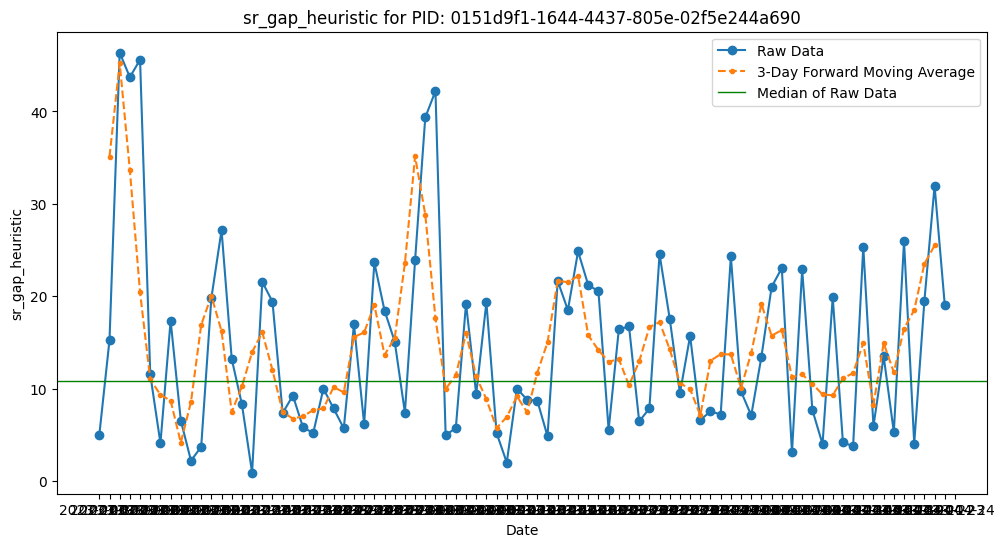

In [12]:
# Visualize a couple subjects with both original and three day smoothed gap

# Moving the target column forward 1 day as it is the mean of (current day + 1, cd + 2, cd + 3)
# so target for day 7, really represents the rolling average  of days 8, 9 and 10, so by moving
# it forward a day it is associated with day 8 instead of day 7

# Selecting two PIDs
pids = df_good['PID'].unique()[:1]

# Filter the dataframe for the PIDs
df_filtered = df_good[df_good['PID'].isin(pids)][['PID', 'trial_date', 'sr_gap_heuristic', 'target']]

# Plot the data for each PID
for pid in pids:
    df_pid = df_filtered[df_filtered['PID'] == pid]
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_pid['trial_date'], df_pid['sr_gap_heuristic'], label='Raw Data', marker='o')
    plt.plot(df_pid['trial_date'], df_pid['target'].shift(1), label='3-Day Forward Moving Average', linestyle='--', marker='.')
    
    # Add a horizontal line at the median of the raw data
    median_value = df_pid['sr_gap_heuristic'].median()
    plt.axhline(median_value, color='green', linestyle='-', linewidth=1, label='Median of Raw Data')
    
    plt.title(f'sr_gap_heuristic for PID: {pid}')
    plt.xlabel('Date')
    plt.ylabel('sr_gap_heuristic')
    plt.legend()
    plt.show()

# Fit Model

In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['subject', 'data_version', 'split_day', 'num_features', 'gap_heuristic', 'linear_reg', 'random_forest', 'xgboost', 'ensemble', 'ffill',
                                   'predictions_lr', 'predictions_rf', 'predictions_xgb', 'predictions_e',
                                   'trainTest_error_dif_lr',
                                   'trainTest_error_dif_rf',
                                   'trainTest_error_dif_xgb',
                                   'trainTest_error_ratio_lr',
                                   'trainTest_error_ratio_rf',
                                   'trainTest_error_ratio_xgb',
                                   'test_score_stability_std_lr',
                                   'test_score_stability_std_rf',
                                   'test_score_stability_std_xgb'
                                   ])

# How many features to use
feature_iterator = [1, 6, 12]

# Loop through subjects
for i in range(len(np.unique(df_good.PID))):
    print("Subject", i)
    
    try:
        # Feature engineering for subject
        df_split = subject_df(df_good, sub_num=i)
        
        # Separate features and target variable
        X = df_split.drop(columns=['target'])
        y = df_split['target']
        
        # Loop through data versions (3)
        for dataVersion in range(3):
            print("Data Version:", dataVersion)
            
            # Filter based on predictive features from MLM for given data version
            if dataVersion == 0:
                # Filter columns_to_keep to include only those that exist in the DataFrame
                filtered_cols = [col for col in feature_filter_all if col in X.columns]
                
            elif dataVersion == 1:
                # Filter columns_to_keep to include only those that exist in the DataFrame
                filtered_cols = [col for col in feature_filter_passive_task if col in X.columns]
                
            elif dataVersion == 2:
                # Filter columns_to_keep to include only those that exist in the DataFrame
                filtered_cols = [col for col in feature_filter_passive if col in X.columns]
            
            # Filter features
            X = X[filtered_cols]

            # Remove initial rows with NaN values for target
            while y.isnull().iloc[0]:
                X = X.iloc[1:].reset_index(drop=True)
                y = y.iloc[1:].reset_index(drop=True)
            
            # Count missing values before imputation
            missing_values_before = y.isnull().sum()

            # Impute missing values in the target variable using forward fill
            y = y.fillna(method='ffill')

            # Count missing values after imputation
            missing_values_after = y.isnull().sum()

            # Calculate the number of imputed values
            imputed_value_count = missing_values_before - missing_values_after

            # Iterate through split points
            for splitDay in range(50, len(X)-3):
                print("Split Day:", splitDay)
                for num_features in feature_iterator:
                    # Ensure there are no more NaN values in y
                    if y.isnull().sum() == 0:
                        # Create train and test sets where we predict the next 3 days only
                        X_train, X_test = X[:splitDay], X[splitDay:splitDay+3]
                        y_train, y_test = y[:splitDay], y[splitDay:splitDay+3]
                        
                        # Handle missing values and standardize features
                        imputer = SimpleImputer(strategy='mean')
                        scaler = StandardScaler()

                        # Feature selection
                        k_best = SelectKBest(score_func=f_regression, k=num_features)

                        # Models
                        lin_reg = ElasticNet()
                        rf = RandomForestRegressor(n_estimators=100)
                        xgb_reg = xgb.XGBRegressor(n_estimators=100)

                        # TimeSeriesSplit
                        tscv = TimeSeriesSplit(n_splits=5)

                        # Pipelines
                        lin_reg_pipeline = Pipeline([
                            ('imputer', imputer),
                            ('scaler', scaler),
                            ('k_best', k_best),
                            ('regressor', lin_reg)
                        ])

                        rf_pipeline = Pipeline([
                            ('imputer', imputer),
                            ('scaler', scaler),
                            ('k_best', k_best),
                            ('regressor', rf)
                        ])

                        xgb_pipeline = Pipeline([
                            ('imputer', imputer),
                            ('scaler', scaler),
                            ('k_best', k_best),
                            ('regressor', xgb_reg)
                        ])

                        # Define the parameter grids for each model
                        param_grid_lin_reg = {
                            'regressor__alpha': [0.1, 1.0, 10.0],  # Values for the overall regularization strength
                            'regressor__l1_ratio': [0.3, 0.5, 0.7]   # Values for the mix between L1 and L2 regularization
                        }

                        param_grid_rf = {
                            #'regressor__n_estimators': [50, 100, 200],
                            'regressor__n_estimators': [50, 100],
                            #'regressor__max_depth': [None, 10, 20, 30]
                            'regressor__max_depth': [None, 20]
                        }

                        param_grid_xgb = {
                            # 'regressor__n_estimators': [50, 100, 200],
                            # 'regressor__learning_rate': [0.01, 0.1, 0.3],
                            # 'regressor__max_depth': [3, 6, 9],
                            # 'regressor__reg_alpha': [0, 0.1, 0.5],
                            # 'regressor__reg_lambda': [0, 0.5, 1]
                            'regressor__n_estimators': [100],
                            'regressor__learning_rate': [0.05, 0.3],
                            'regressor__max_depth': [6],
                            'regressor__reg_alpha': [0],
                            'regressor__reg_lambda': [1]
                        }

                        # Setup GridSearchCV for each model
                        grid_lin_reg = GridSearchCV(lin_reg_pipeline, param_grid_lin_reg, cv=tscv, scoring='neg_mean_squared_error', return_train_score=True)
                        grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=tscv, scoring='neg_mean_squared_error', return_train_score=True)
                        grid_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=tscv, scoring='neg_mean_squared_error', return_train_score=True)

                        # Fit the models
                        grid_lin_reg.fit(X_train, y_train)
                        grid_rf.fit(X_train, y_train)
                        grid_xgb.fit(X_train, y_train)

                        # Print best parameters for the XGBoost model
                        print("Best parameters for XGBoost:", grid_xgb.best_params_)

                        # Best estimators
                        best_lin_reg = grid_lin_reg.best_estimator_
                        best_rf = grid_rf.best_estimator_
                        best_xgb = grid_xgb.best_estimator_

                        # Ensemble with VotingRegressor
                        voting_reg = VotingRegressor(estimators=[
                            ('lin_reg', best_lin_reg),
                            ('rf', best_rf),
                            ('xgb', best_xgb)
                        ])
                        
                        # Cross-validation for ensemble model
                        ensemble_scores = cross_val_score(voting_reg, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
                        ensemble_rmse = np.sqrt(-ensemble_scores.mean())

                        # Feature importance list
                        selector = best_xgb.named_steps['k_best']
                        xgb_model = best_xgb.named_steps['regressor']

                        mask = selector.get_support()  # Boolean mask
                        selected_indices = selector.get_support(indices=True)  # Indices of selected features
                        selected_feature_names = X.columns[selected_indices]

                        importances = xgb_model.feature_importances_

                        feature_importances = sorted(zip(selected_feature_names, importances), key=lambda x: x[1], reverse=True)
                        feature_dict = {feature: importance for feature, importance in feature_importances}

                        # Predict on held out data (3 days)
                        # Make predictions using the best Linear Regression Model
                        best_lin_reg.fit(X_train, y_train)
                        y_pred = best_lin_reg.predict(X_test)
                        prediction_dict_lr = [{'predicted_lr_value': pred, 'actual_value': actual} for pred, actual in zip(y_pred, y_test)]
                        
                        # Make predictions using the best RF model
                        best_rf.fit(X_train, y_train)
                        y_pred = best_rf.predict(X_test)
                        prediction_dict_rf = [{'predicted_rf_value': pred, 'actual_value': actual} for pred, actual in zip(y_pred, y_test)]
                        
                        # Make predictions using the best XGBoost model
                        best_xgb.fit(X_train, y_train)
                        y_pred_ensemble = best_xgb.predict(X_test)
                        prediction_dict_xgb = [{'predicted_xgb_value': pred, 'actual_value': actual} for pred, actual in zip(y_pred, y_test)]
                        
                        # Make predictions using the best Ensemble model
                        voting_reg.fit(X_train, y_train)
                        y_pred = voting_reg.predict(X_test)
                        prediction_dict_e = [{'predicted_e_value': pred, 'actual_value': actual} for pred, actual in zip(y_pred, y_test)]
                        
                        # train/test error comparison
                        def train_test_error_compare(grid_search_cv):
                            """
                            Calculates two metrics comparing train and test score.

                            Args:
                                grid_search_cv (GridSearchCV): The fitted GridSearchCV object.
                            
                            Returns:
                                trainTest_error_dif (float): The difference between the test score (error) and training score (in original units)
                                trainTest_error_ratio (float): The ratio of the test score (error) to the training score (in original units)
                            """
                            # Get index of best fitting model
                            best_index = np.where(grid_search_cv.cv_results_['rank_test_score'] == 1)[0][0]
                            
                            trainTest_error_dif = np.sqrt(-grid_search_cv.cv_results_['mean_test_score'][best_index]) - np.sqrt(-grid_search_cv.cv_results_['mean_train_score'][best_index])
                            trainTest_error_ratio = np.sqrt(-grid_search_cv.cv_results_['mean_test_score'][best_index]) / np.sqrt(-grid_search_cv.cv_results_['mean_train_score'][best_index])
                            
                            return trainTest_error_dif, trainTest_error_ratio

                        trainTest_error_dif_lr, trainTest_error_ratio_lr = train_test_error_compare(grid_lin_reg)
                        trainTest_error_dif_rf, trainTest_error_ratio_rf = train_test_error_compare(grid_rf)
                        trainTest_error_dif_xgb, trainTest_error_ratio_xgb = train_test_error_compare(grid_xgb)
                        
                        # stability of scores across folds
                        # this is different than 'std_test_score' from cv_results_ since it is based on rmse, instead of mse, so is based on original units

                        def test_score_stability(grid_search_cv):
                            """
                            Calculates how much variation there is the test score across folds for the best model

                            Args:
                                grid_search_cv (GridSearchCV): The fitted GridSearchCV object.
                                
                            Returns:
                            test_fold_var (float): The standard deviation of the test score across the cv folds.
                            """
                            # Get index of best fitting model
                            best_index = np.where(grid_search_cv.cv_results_['rank_test_score'] == 1)[0][0]
                            
                            test_fold_var = np.std([np.sqrt(-grid_search_cv.cv_results_['split0_test_score'][best_index]), 
                            np.sqrt(-grid_search_cv.cv_results_['split1_test_score'][best_index]),
                            np.sqrt(-grid_search_cv.cv_results_['split2_test_score'][best_index]),
                            np.sqrt(-grid_search_cv.cv_results_['split3_test_score'][best_index]),
                            np.sqrt(-grid_search_cv.cv_results_['split4_test_score'][best_index])
                            ])
                            
                            return test_fold_var

                        test_score_stability_std_lr = test_score_stability(grid_lin_reg)
                        test_score_stability_std_rf = test_score_stability(grid_rf)
                        test_score_stability_std_xgb = test_score_stability(grid_xgb)
                        
                        # Save results to the DataFrame using pd.concat
                        new_row = pd.DataFrame({
                            'subject': [i],
                            'data_version': dataVersion,
                            'split_day': splitDay,
                            'num_features': num_features,
                            'gap_heuristic': [list(X_test['sr_gap_heuristic'])],
                            'linear_reg': [np.sqrt(-grid_lin_reg.best_score_)],
                            'random_forest': [np.sqrt(-grid_rf.best_score_)],
                            'xgboost': [np.sqrt(-grid_xgb.best_score_)],
                            'ensemble': [ensemble_rmse],
                            'ffill': [imputed_value_count],
                            'feature_import_xgb': [feature_dict],
                            'predictions_lr': [prediction_dict_lr],
                            'predictions_rf': [prediction_dict_rf],
                            'predictions_xgb': [prediction_dict_xgb],
                            'predictions_e': [prediction_dict_e],
                            'trainTest_error_dif_lr': [trainTest_error_dif_lr],
                            'trainTest_error_dif_rf': [trainTest_error_dif_rf],
                            'trainTest_error_dif_xgb': [trainTest_error_dif_xgb],
                            'trainTest_error_ratio_lr': [trainTest_error_ratio_lr],
                            'trainTest_error_ratio_rf': [trainTest_error_ratio_rf],
                            'trainTest_error_ratio_xgb': [trainTest_error_ratio_xgb],
                            'test_score_stability_std_lr': [test_score_stability_std_lr],
                            'test_score_stability_std_rf': [test_score_stability_std_rf],
                            'test_score_stability_std_xgb': [test_score_stability_std_xgb],
                        })
                        results_df = pd.concat([results_df, new_row], ignore_index=True)
                        
                    else:
                        print(f"Skipping subject {i} because the target variable y still contains NaN values after imputation.")
                        continue
    except KeyError as err:
        print(f'Error with subject {i} in subject_df() function: {err}')


Subject 0
Data Version: 0
Split Day: 50
Best parameters for XGBoost: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 6, 'regressor__n_estimators': 100, 'regressor__reg_alpha': 0, 'regressor__reg_lambda': 1}


IndexError: index 4 is out of bounds for axis 0 with size 4

In [ ]:
# train/test error comparison
def train_test_error_compare(grid_search_cv):
    """
    Calculates two metrics comparing train and test score.

    Args:
        grid_search_cv (GridSearchCV): The fitted GridSearchCV object.
    
    Returns:
        trainTest_error_dif (float): The difference between the test score (error) and training score (in original units)
        trainTest_error_ratio (float): The ratio of the test score (error) to the training score (in original units)
    """
    # Get index of best fitting model
    best_index = np.where(grid_search_cv.cv_results_['rank_test_score'] == 1)[0][0]
    
    trainTest_error_dif = np.sqrt(-grid_rf.cv_results_['mean_test_score'][best_index]) - np.sqrt(-grid_rf.cv_results_['mean_train_score'][best_index])
    trainTest_error_ratio = np.sqrt(-grid_rf.cv_results_['mean_test_score'][best_index]) / np.sqrt(-grid_rf.cv_results_['mean_train_score'][best_index])
    
    return trainTest_error_dif, trainTest_error_ratio

In [19]:
best_index = np.where(grid_lin_reg.cv_results_['rank_test_score'] == 1)[0][0]

In [23]:
np.sqrt(-grid_rf.cv_results_['mean_test_score'][best_index]) - np.sqrt(-grid_rf.cv_results_['mean_train_score'][best_index])

IndexError: index 4 is out of bounds for axis 0 with size 4

In [21]:
grid_lin_reg.cv_results_['mean_test_score'][best_index]

-0.032748534140942934

In [22]:
grid_lin_reg.cv_results_['mean_train_score'][best_index]

-0.06602441598369736

In [14]:
train_test_error_compare(grid_lin_reg)

IndexError: index 4 is out of bounds for axis 0 with size 4

In [15]:
grid_lin_reg.cv_results_['rank_test_score']


array([9, 8, 7, 6, 1, 1, 1, 1, 1], dtype=int32)

In [16]:
np.where(grid_lin_reg.cv_results_['rank_test_score'] == 1)[0][0]

4

In [307]:
results_df.to_csv('results_df2.csv', index=False)

# Analyze Results

In [311]:
# Error ratio across average for number of features
import seaborn as sns

<Figure size 1200x600 with 0 Axes>

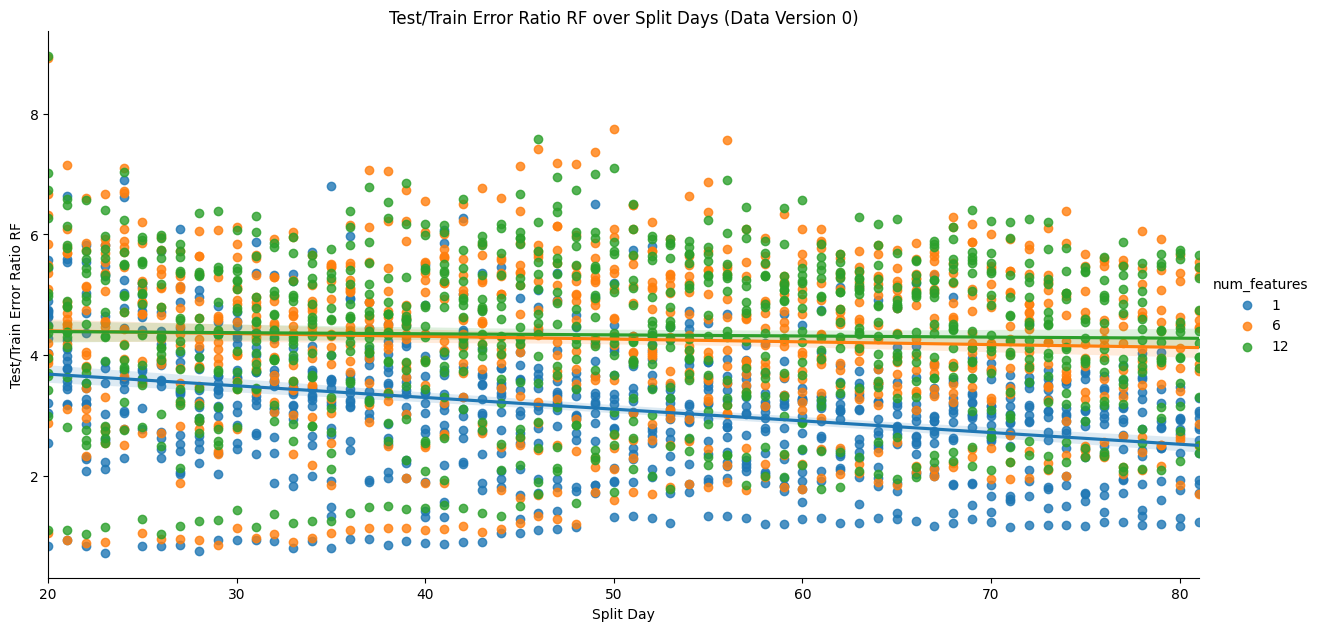

In [340]:
# Filter the data for data_version == 0
filtered_data = results_df[results_df['data_version'] == 0]

filtered_data['split_day'] = pd.to_numeric(filtered_data['split_day'], errors='coerce')
filtered_data['trainTest_error_ratio_rf'] = pd.to_numeric(filtered_data['trainTest_error_ratio_rf'], errors='coerce')
filtered_data['num_features'] = pd.to_numeric(filtered_data['num_features'], errors='coerce')

# Create the scatter plot with line of best fit for each num_features grouping
plt.figure(figsize=(12, 6))
# Using seaborn's lmplot to add a line of best fit
sns.lmplot(data=filtered_data, x='split_day', y='trainTest_error_ratio_rf', hue='num_features', height=6, aspect=2)

plt.title('Test/Train Error Ratio RF over Split Days (Data Version 0)')
plt.xlabel('Split Day')
plt.ylabel('Test/Train Error Ratio RF')
plt.show()

In [341]:
results_df = pd.read_csv('results_df2.csv')

<Figure size 1200x600 with 0 Axes>

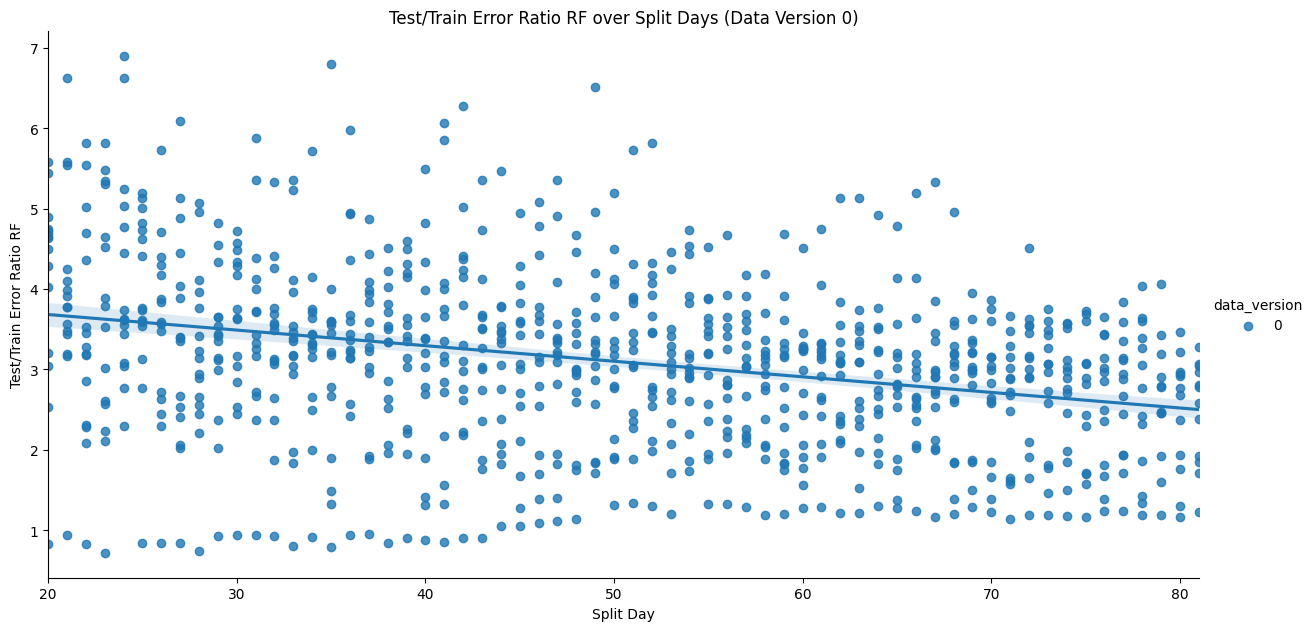

In [342]:
# Filter the data for data_version == 0
filtered_data = results_df[results_df['num_features'] == 1]

filtered_data['split_day'] = pd.to_numeric(filtered_data['split_day'], errors='coerce')
filtered_data['trainTest_error_ratio_rf'] = pd.to_numeric(filtered_data['trainTest_error_ratio_rf'], errors='coerce')
filtered_data['data_version'] = pd.to_numeric(filtered_data['data_version'], errors='coerce')

# Create the scatter plot with line of best fit for each data_version grouping
plt.figure(figsize=(12, 6))
# Using seaborn's lmplot to add a line of best fit
sns.lmplot(data=filtered_data, x='split_day', y='trainTest_error_ratio_rf', hue='data_version', height=6, aspect=2)

plt.title('Test/Train Error Ratio RF over Split Days (Data Version 0)')
plt.xlabel('Split Day')
plt.ylabel('Test/Train Error Ratio RF')
plt.show()

<Figure size 1200x600 with 0 Axes>

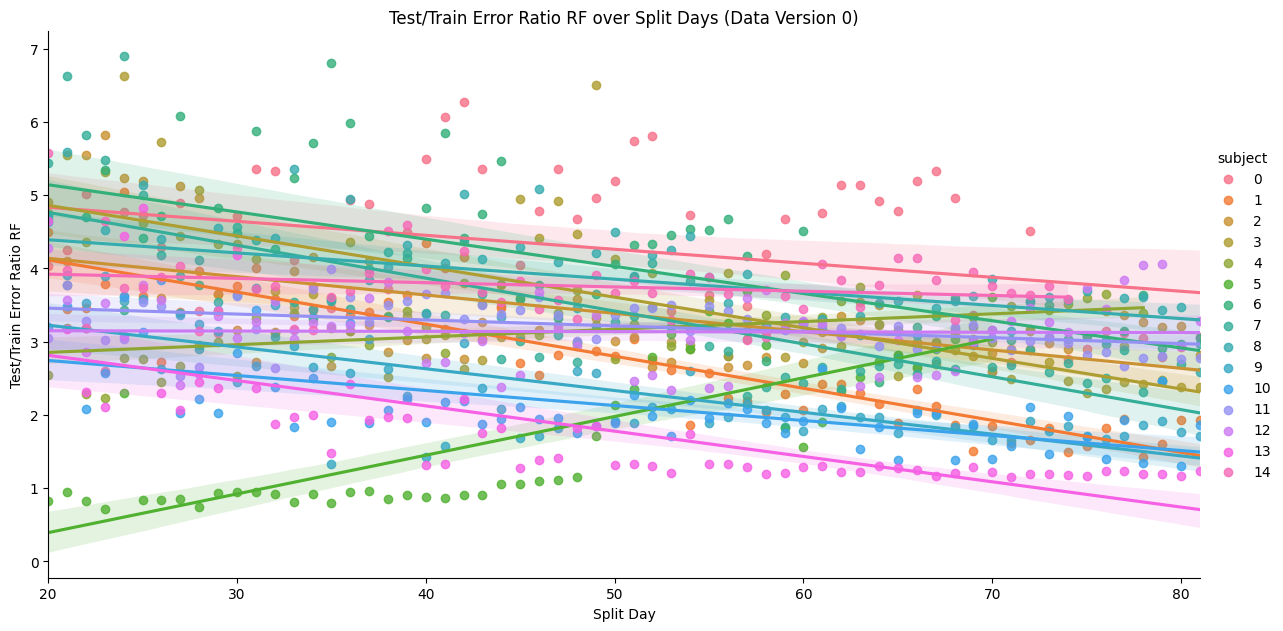

In [343]:
# Filter the data for data_version == 0
filtered_data = results_df[results_df['num_features'] == 1]

filtered_data['split_day'] = pd.to_numeric(filtered_data['split_day'], errors='coerce')
filtered_data['trainTest_error_ratio_rf'] = pd.to_numeric(filtered_data['trainTest_error_ratio_rf'], errors='coerce')
filtered_data['data_version'] = pd.to_numeric(filtered_data['data_version'], errors='coerce')

# Create the scatter plot with line of best fit for each data_version grouping
plt.figure(figsize=(12, 6))
# Using seaborn's lmplot to add a line of best fit
sns.lmplot(data=filtered_data, x='split_day', y='trainTest_error_ratio_rf', hue='subject', height=6, aspect=2)

plt.title('Test/Train Error Ratio RF over Split Days (Data Version 0)')
plt.xlabel('Split Day')
plt.ylabel('Test/Train Error Ratio RF')
plt.show()

<Figure size 1200x600 with 0 Axes>

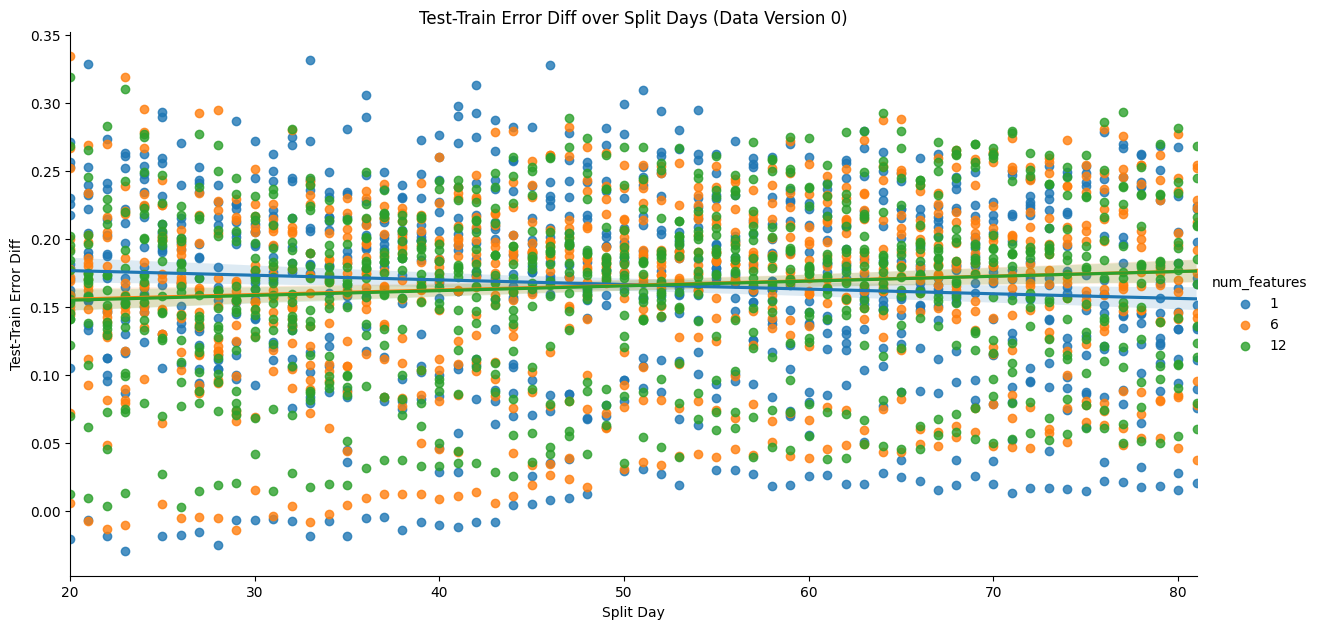

In [344]:
# Filter the data for data_version == 0
filtered_data = results_df[results_df['data_version'] == 0]

filtered_data['split_day'] = pd.to_numeric(filtered_data['split_day'], errors='coerce')
filtered_data['trainTest_error_dif_rf'] = pd.to_numeric(filtered_data['trainTest_error_dif_rf'], errors='coerce')
filtered_data['num_features'] = pd.to_numeric(filtered_data['num_features'], errors='coerce')

# Create the scatter plot with line of best fit for each num_features grouping
plt.figure(figsize=(12, 6))
# Using seaborn's lmplot to add a line of best fit
sns.lmplot(data=filtered_data, x='split_day', y='trainTest_error_dif_rf', hue='num_features', height=6, aspect=2)

plt.title('Test-Train Error Diff over Split Days (Data Version 0)')
plt.xlabel('Split Day')
plt.ylabel('Test-Train Error Diff')
plt.show()

<Figure size 1200x600 with 0 Axes>

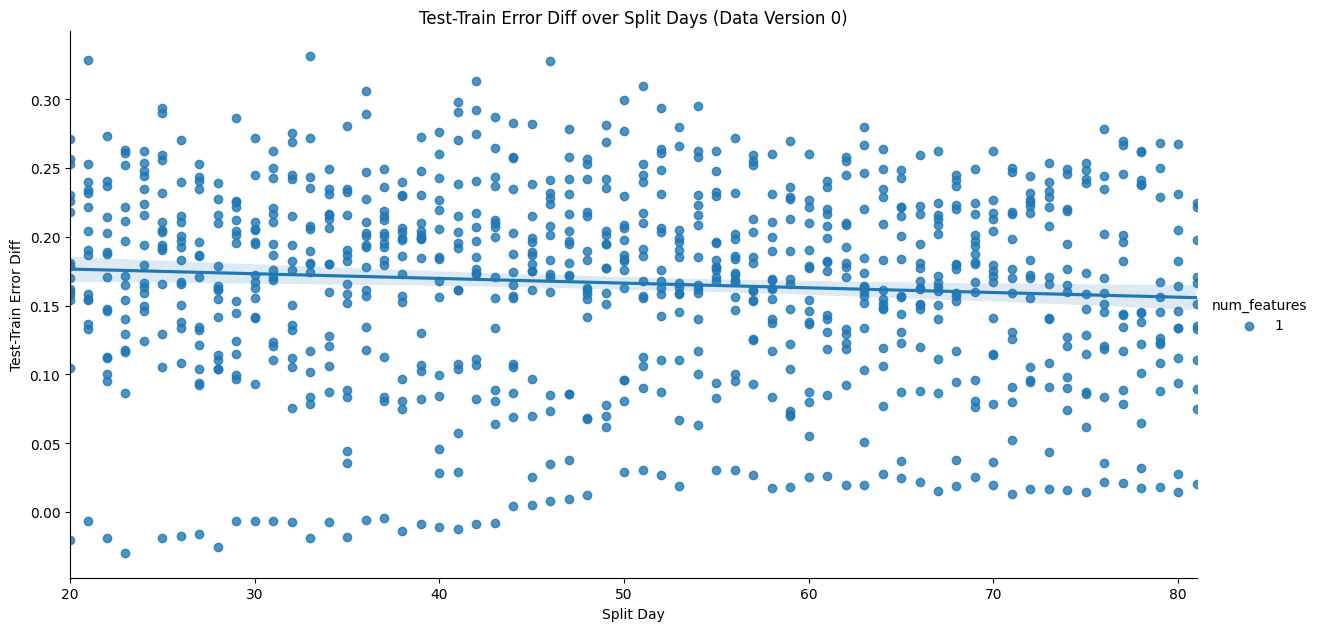

In [345]:
# Filter the data for data_version == 0
filtered_data = results_df[results_df['num_features'] == 1]

filtered_data['split_day'] = pd.to_numeric(filtered_data['split_day'], errors='coerce')
filtered_data['trainTest_error_dif_rf'] = pd.to_numeric(filtered_data['trainTest_error_dif_rf'], errors='coerce')
filtered_data['num_features'] = pd.to_numeric(filtered_data['num_features'], errors='coerce')

# Create the scatter plot with line of best fit for each num_features grouping
plt.figure(figsize=(12, 6))
# Using seaborn's lmplot to add a line of best fit
sns.lmplot(data=filtered_data, x='split_day', y='trainTest_error_dif_rf', hue='num_features', height=6, aspect=2)

plt.title('Test-Train Error Diff over Split Days (Data Version 0)')
plt.xlabel('Split Day')
plt.ylabel('Test-Train Error Diff')
plt.show()

In [352]:
print(filtered_data['random_forest'].dtype)
print(filtered_data['random_forest'].describe())


float64
count    2725.000000
mean        0.229693
std         0.068052
min         0.070535
25%         0.188777
50%         0.234432
75%         0.279732
max         0.408516
Name: random_forest, dtype: float64


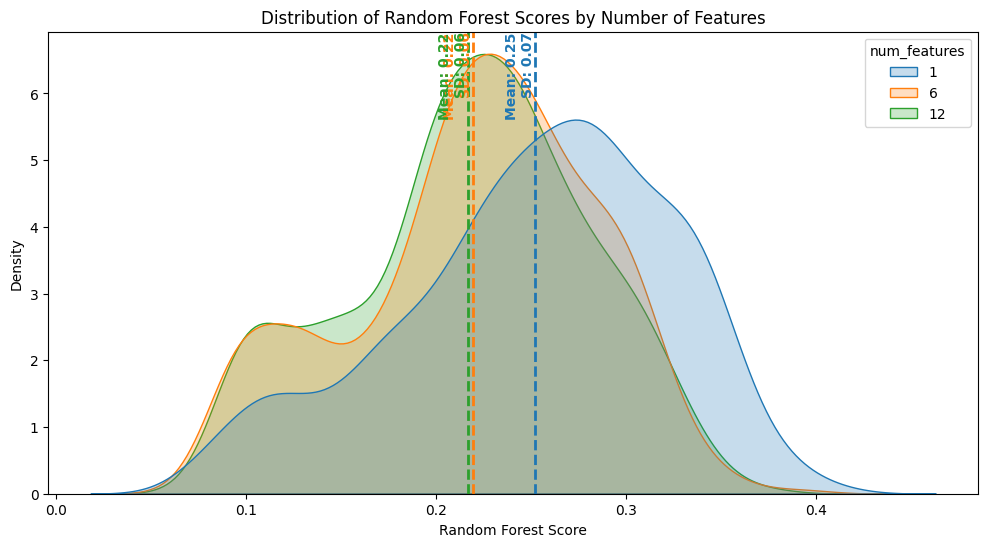

In [357]:
filtered_data = results_df[results_df['data_version'] == 0]

filtered_data['num_features'] = filtered_data['num_features'].astype('category')

plt.figure(figsize=(12, 6))

# Plot the distribution of 'random_forest' for each 'num_features' value
hue_order = sorted(filtered_data['num_features'].unique())

sns.kdeplot(data=filtered_data, x='random_forest', hue='num_features', 
            hue_order=hue_order, common_norm=False, fill=True)

# Calculate mean and std for each group
stats = filtered_data.groupby('num_features')['random_forest'].agg(['mean', 'std'])

# Add mean lines and annotations
for num_features, (mean, std) in stats.iterrows():
    color = plt.gca()._get_lines.get_next_color()
    plt.axvline(mean, color=color, linestyle='--', linewidth=2)
    plt.text(mean, plt.gca().get_ylim()[1], f'Mean: {mean:.2f}\nSD: {std:.2f}', 
             rotation=90, va='top', ha='right', color=color, fontweight='bold')

plt.title('Distribution of Random Forest Scores by Number of Features')
plt.xlabel('Random Forest Score')
plt.ylabel('Density')
plt.show()


In [360]:
results_df

,subject,data_version,split_day,num_features,gap_heuristic,linear_reg,random_forest,xgboost,ensemble,ffill,...,trainTest_error_dif_lr,trainTest_error_dif_rf,trainTest_error_dif_xgb,trainTest_error_ratio_lr,trainTest_error_ratio_rf,trainTest_error_ratio_xgb,test_score_stability_std_lr,test_score_stability_std_rf,test_score_stability_std_xgb,feature_import_xgb
0,0,0,20,1,20 5.8\n21 5.2\n22 10.0\nName: sr_g...,0.287318,0.300437,0.261280,0.278301,3,...,0.225903,0.225903,0.225903,4.030883,4.030883,4.030883,0.149466,0.141513,0.108037,{'passive_sk_device_total_usage_health_and_fit...
1,0,0,20,6,20 5.8\n21 5.2\n22 10.0\nName: sr_g...,0.425137,0.194188,0.237129,0.238587,3,...,0.157711,0.144067,0.157711,4.023400,3.874353,4.023400,0.179525,0.076288,0.106451,{'sr_DAILY_past24_leisureNonSolo_exponential_r...
2,0,0,20,12,20 5.8\n21 5.2\n22 10.0\nName: sr_g...,0.483106,0.188717,0.167871,0.224597,3,...,0.144803,0.140915,0.144803,4.047244,3.947846,4.047244,0.226762,0.086258,0.041046,{'task_hanoi_movesTime_model_predict': 0.64829...
3,0,0,21,1,21 5.20\n22 10.00\n23 7.85\nName: s...,0.292137,0.303483,0.340354,0.260128,3,...,0.240828,0.231989,0.231989,4.424901,4.244907,4.244907,0.153435,0.142985,0.181042,{'passive_sk_device_total_usage_health_and_fit...
4,0,0,21,6,21 5.20\n22 10.00\n23 7.85\nName: s...,0.307933,0.205864,0.293832,0.258570,3,...,0.161972,0.161972,0.165581,4.690269,4.690269,4.853785,0.127327,0.086615,0.174970,{'task_trailmaking_alphaNumeric_time_rolling_m...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,14,0,72,12,1262 NaN\n1263 NaN\n1264 NaN\nName: sr_g...,0.478040,0.201870,0.231808,0.254454,8,...,0.157494,0.157494,0.157494,4.549059,4.549059,4.549059,0.265716,0.059819,0.045663,{'sr_DAILY_past24_procrastination_rolling_mean...
2721,14,0,73,1,1263 NaN\n1264 NaN\n1265 90.6\nName...,0.260393,0.283555,0.290408,0.269764,8,...,0.210852,0.208074,0.210852,3.788927,3.756646,3.788927,0.101025,0.081455,0.071811,{'sr_DAILY_past24_procrastination_rolling_mean...
2722,14,0,73,6,1263 NaN\n1264 NaN\n1265 90.6\nName...,0.270760,0.233819,0.241287,0.238022,8,...,0.189158,0.189135,0.189135,4.979398,5.232742,5.232742,0.100117,0.075559,0.054453,{'sr_DAILY_past24_procrastination_rolling_mean...
2723,14,0,73,12,1263 NaN\n1264 NaN\n1265 90.6\nName...,0.352543,0.241285,0.255851,0.265761,8,...,0.198994,0.195462,0.198994,5.459801,5.265542,5.459801,0.095963,0.080081,0.063807,{'sr_DAILY_past24_procrastination_rolling_mean...


## Individual level

In [78]:
results_df

,subject,data_version,split_day,linear_reg,random_forest,xgboost,ensemble,ffill,predictions_lr,predictions_rf,predictions_xgb,predictions_e,feature_import_xgb
0,0,0,20,0.483106,0.190516,0.167871,0.226252,3,"[{'predicted_lr_value': 0.02722104827359903, '...","[{'predicted_rf_value': 0.12552759740259734, '...","[{'predicted_xgb_value': 0.12552759740259734, ...","[{'predicted_e_value': 0.08832141087574102, 'a...",{'task_hanoi_movesTime_model_predict': 0.64829...
1,0,0,21,0.560484,0.190031,0.146830,0.198569,3,"[{'predicted_lr_value': -0.1668015179888182, '...","[{'predicted_rf_value': 0.09540584415584406, '...","[{'predicted_xgb_value': 0.09540584415584406, ...","[{'predicted_e_value': 0.003869155404158923, '...",{'task_hanoi_movesTime_model_predict': 0.42480...
2,0,0,22,0.246302,0.124297,0.152557,0.119458,3,"[{'predicted_lr_value': -0.013139851796583835,...","[{'predicted_rf_value': 0.12129058441558438, '...","[{'predicted_xgb_value': 0.12129058441558438, ...","[{'predicted_e_value': 0.06237538694598866, 'a...",{'passive_sk_device_total_usage_health_and_fit...
3,0,0,23,0.486687,0.122936,0.158575,0.211729,3,"[{'predicted_lr_value': -0.12299898509316781, ...","[{'predicted_rf_value': 0.10833603896103895, '...","[{'predicted_xgb_value': 0.10833603896103895, ...","[{'predicted_e_value': 0.03814742555013415, 'a...",{'passive_sk_device_total_usage_health_and_fit...
4,0,0,24,0.583403,0.268759,0.305795,0.300993,3,"[{'predicted_lr_value': -0.10534773731091293, ...","[{'predicted_rf_value': 0.11329545454545453, '...","[{'predicted_xgb_value': 0.11329545454545453, ...","[{'predicted_e_value': 0.04020557134796884, 'a...",{'affect_neg_lazy_exponential_rolling_mean_7':...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17383,94,0,48,0.324731,0.235372,0.247277,0.240861,3,"[{'predicted_lr_value': 0.4445329061052149, 'a...","[{'predicted_rf_value': 0.4193241980691375, 'a...","[{'predicted_xgb_value': 0.4193241980691375, '...","[{'predicted_e_value': 0.46674724159060116, 'a...","{'sr_gap_heuristic_rolling_mean_7': 0.4171294,..."
17384,94,0,49,0.313334,0.225361,0.244274,0.238552,3,"[{'predicted_lr_value': 0.44728645981624165, '...","[{'predicted_rf_value': 0.402818436624105, 'ac...","[{'predicted_xgb_value': 0.402818436624105, 'a...","[{'predicted_e_value': 0.42094074904387807, 'a...",{'sr_gap_heuristic_rolling_mean_7': 0.27554345...
17385,94,0,50,0.380475,0.211563,0.241330,0.220985,3,"[{'predicted_lr_value': 0.5189542860924528, 'a...","[{'predicted_rf_value': 0.29975085643101823, '...","[{'predicted_xgb_value': 0.29975085643101823, ...","[{'predicted_e_value': 0.3648918460092309, 'ac...",{'sr_gap_heuristic_rolling_mean_7': 0.41212186...
17386,94,0,51,8.101042,0.192760,0.207418,2.705783,3,"[{'predicted_lr_value': 0.05207257079104011, '...","[{'predicted_rf_value': 0.2658299595141699, 'a...","[{'predicted_xgb_value': 0.2658299595141699, '...","[{'predicted_e_value': 0.18314506318679333, 'a...","{'sr_gap_heuristic_rolling_mean_7': 0.540286, ..."


In [13]:
results_df.predictions_xgb[0]

"[{'predicted_xgb_value': 0.12552759740259734, 'actual_value': 0.08603896103896103}, {'predicted_xgb_value': 0.1064204545454545, 'actual_value': 0.09009740259740262}, {'predicted_xgb_value': 0.13434253246753244, 'actual_value': 0.14650974025974026}]"

In [14]:
results_df.predictions_xgb[1]

"[{'predicted_xgb_value': 0.09540584415584406, 'actual_value': 0.09009740259740262}, {'predicted_xgb_value': 0.11513392857142846, 'actual_value': 0.14650974025974026}, {'predicted_xgb_value': 0.10031249999999992, 'actual_value': 0.13271103896103895}]"

In [79]:
# Save results
results_df.to_csv('results_df.csv', index=False)

In [11]:
results_df = pd.read_csv('results_df.csv')

In [12]:
results_df.loc[results_df.subject==0]

,subject,data_version,split_day,linear_reg,random_forest,xgboost,ensemble,ffill,predictions_lr,predictions_rf,predictions_xgb,predictions_e,feature_import_xgb
0,0,0,20,0.483106,0.190516,0.167871,0.226252,3,"[{'predicted_lr_value': 0.02722104827359903, '...","[{'predicted_rf_value': 0.12552759740259734, '...","[{'predicted_xgb_value': 0.12552759740259734, ...","[{'predicted_e_value': 0.08832141087574102, 'a...",{'task_hanoi_movesTime_model_predict': 0.64829...
1,0,0,21,0.560484,0.190031,0.146830,0.198569,3,"[{'predicted_lr_value': -0.1668015179888182, '...","[{'predicted_rf_value': 0.09540584415584406, '...","[{'predicted_xgb_value': 0.09540584415584406, ...","[{'predicted_e_value': 0.003869155404158923, '...",{'task_hanoi_movesTime_model_predict': 0.42480...
2,0,0,22,0.246302,0.124297,0.152557,0.119458,3,"[{'predicted_lr_value': -0.013139851796583835,...","[{'predicted_rf_value': 0.12129058441558438, '...","[{'predicted_xgb_value': 0.12129058441558438, ...","[{'predicted_e_value': 0.06237538694598866, 'a...",{'passive_sk_device_total_usage_health_and_fit...
3,0,0,23,0.486687,0.122936,0.158575,0.211729,3,"[{'predicted_lr_value': -0.12299898509316781, ...","[{'predicted_rf_value': 0.10833603896103895, '...","[{'predicted_xgb_value': 0.10833603896103895, ...","[{'predicted_e_value': 0.03814742555013415, 'a...",{'passive_sk_device_total_usage_health_and_fit...
4,0,0,24,0.583403,0.268759,0.305795,0.300993,3,"[{'predicted_lr_value': -0.10534773731091293, ...","[{'predicted_rf_value': 0.11329545454545453, '...","[{'predicted_xgb_value': 0.11329545454545453, ...","[{'predicted_e_value': 0.04020557134796884, 'a...",{'affect_neg_lazy_exponential_rolling_mean_7':...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0,2,77,0.436974,0.195996,0.237511,0.248590,0,"[{'predicted_lr_value': 0.17057776109982498, '...","[{'predicted_rf_value': 0.22715909090909084, '...","[{'predicted_xgb_value': 0.22715909090909084, ...","[{'predicted_e_value': 0.19975937741998684, 'a...",{'passive_sk_device_total_usage_health_and_fit...
182,0,2,78,0.453560,0.195424,0.234098,0.213019,0,"[{'predicted_lr_value': -0.11573799734094614, ...","[{'predicted_rf_value': 0.18716720779220775, '...","[{'predicted_xgb_value': 0.18716720779220775, ...","[{'predicted_e_value': 0.08324291301977868, 'a...",{'passive_sk_device_total_usage_health_and_fit...
183,0,2,79,0.332975,0.191082,0.213456,0.204024,0,"[{'predicted_lr_value': 0.12364674652332472, '...","[{'predicted_rf_value': 0.250543831168831, 'ac...","[{'predicted_xgb_value': 0.250543831168831, 'a...","[{'predicted_e_value': 0.2246667917329945, 'ac...",{'passive_sk_device_total_usage_health_and_fit...
184,0,2,80,0.434228,0.186152,0.200604,0.206390,0,"[{'predicted_lr_value': -0.11268062314354792, ...","[{'predicted_rf_value': 0.2937297077922077, 'a...","[{'predicted_xgb_value': 0.2937297077922077, '...","[{'predicted_e_value': 0.1564608350979222, 'ac...",{'passive_sk_device_total_usage_health_and_fit...


In [40]:
results_df.describe()

,subject,data_version,split_day,linear_reg,random_forest,xgboost,ensemble,ffill
count,17388.000000,17388.000000,17388.000000,1.738800e+04,17388.000000,17388.000000,1.738800e+04,17388.000000
mean,46.631125,0.998102,50.280711,1.931801e+11,0.233327,0.257881,6.439336e+10,1.970094
std,27.119329,0.816905,17.818972,1.339661e+13,0.053181,0.060597,4.465537e+12,4.276629
min,0.000000,0.000000,20.000000,9.655213e-02,0.065657,0.056379,7.724520e-02,0.000000
25%,23.000000,0.000000,35.000000,3.569918e-01,0.197532,0.217268,2.401885e-01,0.000000
50%,47.000000,1.000000,50.000000,4.994170e-01,0.232619,0.256865,2.939453e-01,0.000000
75%,70.000000,2.000000,66.000000,8.679142e-01,0.266765,0.294854,3.879925e-01,3.000000
max,94.000000,2.000000,81.000000,1.100952e+15,0.448274,0.554194,3.669840e+14,30.000000


In [41]:
import ast

ast.literal_eval(results_df.predictions_rf[0])

[{'predicted_rf_value': 0.12552759740259734,
  'actual_value': 0.08603896103896103},
 {'predicted_rf_value': 0.1064204545454545,
  'actual_value': 0.09009740259740262},
 {'predicted_rf_value': 0.13434253246753244,
  'actual_value': 0.14650974025974026}]

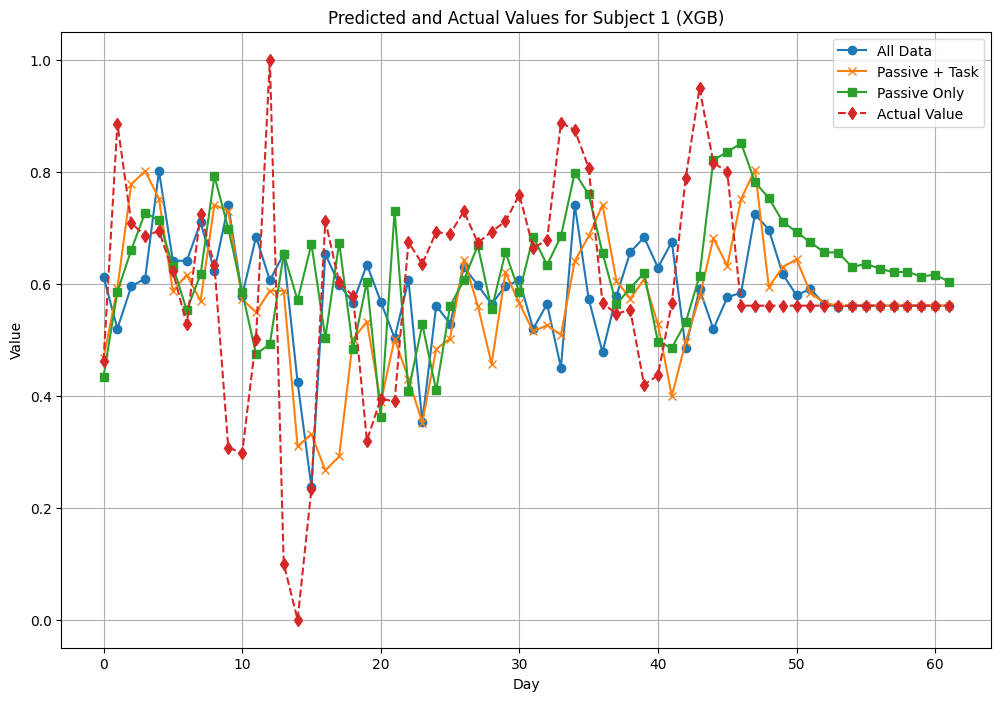

In [194]:
# Extract the predictions_xgb column for subject 0 and data_version 0, 1, and 2
sub_num = 11

subject_0_data = results_df[results_df['subject'] == sub_num]
data_versions = [0, 1, 2]

# Extract all the actual and predicted values for subject 0 and data_version 0, 1, and 2
actual_values = []
predicted_values = {0: [], 1: [], 2: []}

for data_version in data_versions:
    data = subject_0_data[subject_0_data['data_version'] == data_version]
    for _, row in data.iterrows():
        day_plus1_predict = ast.literal_eval(row['predictions_xgb'])[0]['predicted_xgb_value']
        
        # Store actual and predicted values
        if data_version == 0:
            actual = ast.literal_eval(row['predictions_xgb'])[0]['actual_value']
            actual_values.append(actual)
        predicted_values[data_version].append(day_plus1_predict)

# Plot the values
plt.figure(figsize=(12, 8))
plt.plot(predicted_values[0], label='All Data', marker='o')
plt.plot(predicted_values[1], label='Passive + Task', marker='x')
plt.plot(predicted_values[2], label='Passive Only', marker='s')
plt.plot(actual_values, label='Actual Value', marker='d', linestyle='--')

plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Predicted and Actual Values for Subject 1 (XGB)')
plt.legend()
plt.grid(True)
plt.show()

In [195]:
plot_results = pd.DataFrame(predicted_values)
plot_results.columns = ['all', 'task_passive', 'passive']
plot_results['actual'] = actual_values

# Error at each time point
plot_results['all_error'] = np.abs(plot_results['all'] - plot_results['actual'])
plot_results['task_passive_error'] = np.abs(plot_results['task_passive'] - plot_results['actual'])
plot_results['passive_error'] = np.abs(plot_results['passive'] - plot_results['actual'])

# Cumulative error
plot_results['cumulative_all_error'] = plot_results['all_error'].cumsum()
plot_results['cumulative_task_passive_error'] = plot_results['task_passive_error'].cumsum()
plot_results['cumulative_passive_error'] = plot_results['passive_error'].cumsum()

plot_results

,all,task_passive,passive,actual,all_error,task_passive_error,passive_error,cumulative_all_error,cumulative_task_passive_error,cumulative_passive_error
0,0.612483,0.467144,0.434283,0.462500,1.499833e-01,4.644444e-03,0.028217,0.149983,0.004644,0.028217
1,0.519906,0.592278,0.585869,0.885833,3.659278e-01,2.935556e-01,0.299964,0.515911,0.298200,0.328181
2,0.595239,0.777744,0.660394,0.708611,1.133722e-01,6.913333e-02,0.048217,0.629283,0.367333,0.376397
3,0.609231,0.801156,0.727042,0.685278,7.604722e-02,1.158778e-01,0.041764,0.705331,0.483211,0.418161
4,0.801261,0.751739,0.712922,0.694167,1.070944e-01,5.757222e-02,0.018756,0.812425,0.540783,0.436917
...,...,...,...,...,...,...,...,...,...,...
57,0.560833,0.560833,0.620305,0.560833,5.551115e-16,5.551115e-16,0.059472,8.594969,9.139093,8.894421
58,0.560833,0.560833,0.621300,0.560833,5.551115e-16,5.551115e-16,0.060467,8.594969,9.139093,8.954888
59,0.560833,0.560833,0.612822,0.560833,5.551115e-16,5.551115e-16,0.051989,8.594969,9.139093,9.006877
60,0.560833,0.560833,0.616299,0.560833,2.220446e-16,2.220446e-16,0.055465,8.594969,9.139093,9.062343


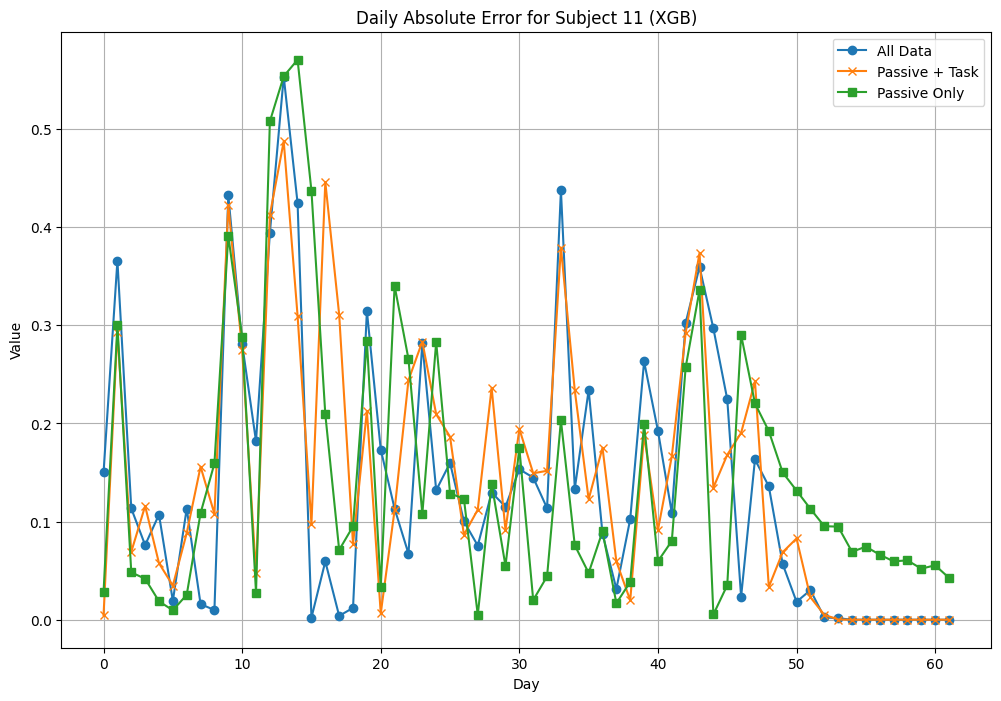

In [196]:
# Plot the values
plt.figure(figsize=(12, 8))
plt.plot(plot_results['all_error'], label='All Data', marker='o')
plt.plot(plot_results['task_passive_error'], label='Passive + Task', marker='x')
plt.plot(plot_results['passive_error'], label='Passive Only', marker='s')

plt.xlabel('Day')
plt.ylabel('Value')
plt.title(f'Daily Absolute Error for Subject {sub_num} (XGB)')
plt.legend()
plt.grid(True)
plt.show()

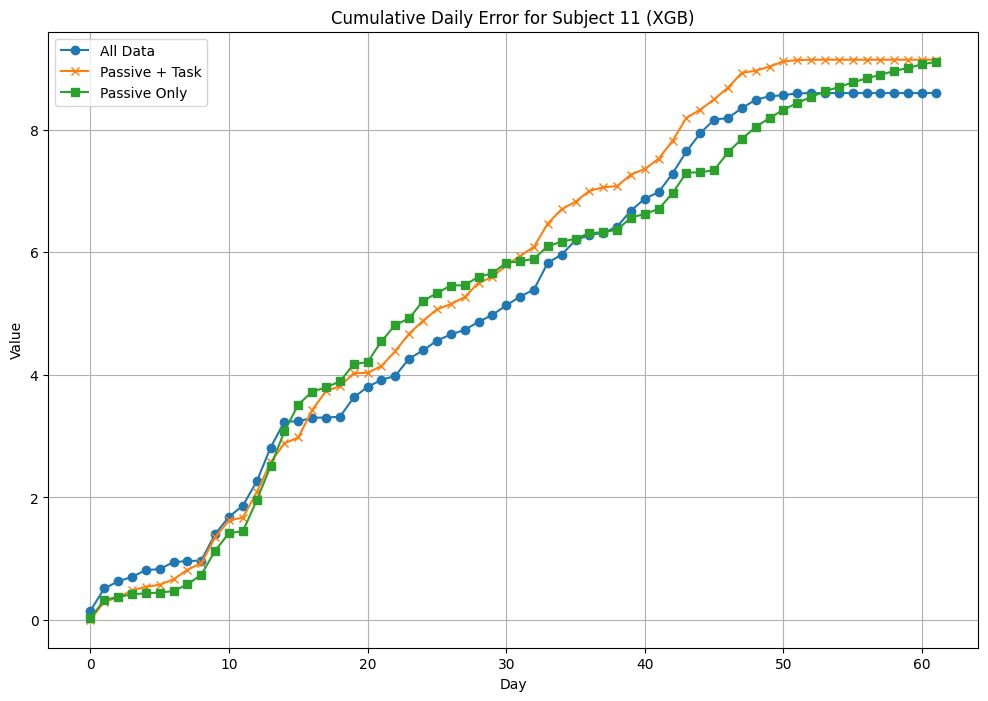

In [197]:
# Plot the values
plt.figure(figsize=(12, 8))
plt.plot(plot_results['cumulative_all_error'], label='All Data', marker='o')
plt.plot(plot_results['cumulative_task_passive_error'], label='Passive + Task', marker='x')
plt.plot(plot_results['cumulative_passive_error'], label='Passive Only', marker='s')

plt.xlabel('Day')
plt.ylabel('Value')
plt.title(f'Cumulative Daily Error for Subject {sub_num} (XGB)')
plt.legend()
plt.grid(True)
plt.show()

## Group level

In [80]:
# Remove subject 94
results_group_df = results_df[results_df['subject'] != 94]

# Convert the string representation of dictionaries in 'predictions_rf' column to actual dictionaries
results_group_df['predictions_rf'] = results_group_df['predictions_rf'].apply(ast.literal_eval)

# Initialize new columns
results_group_df['day_1_predict'] = None
results_group_df['day_2_predict'] = None
results_group_df['day_3_predict'] = None
results_group_df['day_1_actual'] = None
results_group_df['day_2_actual'] = None
results_group_df['day_3_actual'] = None

# Extract values for the new columns
for index, row in results_group_df.iterrows():
    predictions = row['predictions_rf']
    results_group_df.at[index, 'day_1_predict'] = predictions[0]['predicted_rf_value']
    results_group_df.at[index, 'day_2_predict'] = predictions[1]['predicted_rf_value']
    results_group_df.at[index, 'day_3_predict'] = predictions[2]['predicted_rf_value']
    results_group_df.at[index, 'day_1_actual'] = predictions[0]['actual_value']
    results_group_df.at[index, 'day_2_actual'] = predictions[1]['actual_value']
    results_group_df.at[index, 'day_3_actual'] = predictions[2]['actual_value']

In [81]:
# List of columns to convert to float64
columns_to_convert = [
    'day_1_predict',
    'day_2_predict',
    'day_3_predict',
    'day_1_actual',
    'day_2_actual',
    'day_3_actual'
    ]

# Convert the specified columns to float64
results_group_df[columns_to_convert] = results_group_df[columns_to_convert].astype('float64')


In [82]:
results_group_df.head()

,subject,data_version,split_day,linear_reg,random_forest,xgboost,ensemble,ffill,predictions_lr,predictions_rf,predictions_xgb,predictions_e,feature_import_xgb,day_1_predict,day_2_predict,day_3_predict,day_1_actual,day_2_actual,day_3_actual
0,0,0,20,0.483106,0.190516,0.167871,0.226252,3,"[{'predicted_lr_value': 0.02722104827359903, '...","[{'predicted_rf_value': 0.12552759740259734, '...","[{'predicted_xgb_value': 0.12552759740259734, ...","[{'predicted_e_value': 0.08832141087574102, 'a...",{'task_hanoi_movesTime_model_predict': 0.64829...,0.125528,0.106420,0.134343,0.086039,0.090097,0.146510
1,0,0,21,0.560484,0.190031,0.146830,0.198569,3,"[{'predicted_lr_value': -0.1668015179888182, '...","[{'predicted_rf_value': 0.09540584415584406, '...","[{'predicted_xgb_value': 0.09540584415584406, ...","[{'predicted_e_value': 0.003869155404158923, '...",{'task_hanoi_movesTime_model_predict': 0.42480...,0.095406,0.115134,0.100312,0.090097,0.146510,0.132711
2,0,0,22,0.246302,0.124297,0.152557,0.119458,3,"[{'predicted_lr_value': -0.013139851796583835,...","[{'predicted_rf_value': 0.12129058441558438, '...","[{'predicted_xgb_value': 0.12129058441558438, ...","[{'predicted_e_value': 0.06237538694598866, 'a...",{'passive_sk_device_total_usage_health_and_fit...,0.121291,0.131558,0.144578,0.146510,0.132711,0.278409
3,0,0,23,0.486687,0.122936,0.158575,0.211729,3,"[{'predicted_lr_value': -0.12299898509316781, ...","[{'predicted_rf_value': 0.10833603896103895, '...","[{'predicted_xgb_value': 0.10833603896103895, ...","[{'predicted_e_value': 0.03814742555013415, 'a...",{'passive_sk_device_total_usage_health_and_fit...,0.108336,0.125974,0.088588,0.132711,0.278409,0.290584
4,0,0,24,0.583403,0.268759,0.305795,0.300993,3,"[{'predicted_lr_value': -0.10534773731091293, ...","[{'predicted_rf_value': 0.11329545454545453, '...","[{'predicted_xgb_value': 0.11329545454545453, ...","[{'predicted_e_value': 0.04020557134796884, 'a...",{'affect_neg_lazy_exponential_rolling_mean_7':...,0.113295,0.103701,0.268669,0.278409,0.290584,0.363231


In [83]:
# Calculate absolute error
results_group_df['day_1_error_abs'] = np.abs(results_group_df['day_1_predict'] - results_group_df['day_1_actual'])
results_group_df['day_2_error_abs'] = np.abs(results_group_df['day_2_predict'] - results_group_df['day_2_actual'])
results_group_df['day_3_error_abs'] = np.abs(results_group_df['day_3_predict'] - results_group_df['day_3_actual'])

In [86]:
# Calculate cumulative error
results_group_df['day_1_error_cumsum'] = results_group_df.groupby(['subject', 'data_version'])['day_1_error_abs'].cumsum().reset_index(drop=True)
results_group_df['day_2_error_cumsum'] = results_group_df.groupby(['subject', 'data_version'])['day_2_error_abs'].cumsum().reset_index(drop=True)
results_group_df['day_3_error_cumsum'] = results_group_df.groupby(['subject', 'data_version'])['day_3_error_abs'].cumsum().reset_index(drop=True)

In [87]:
results_group_df

,subject,data_version,split_day,linear_reg,random_forest,xgboost,ensemble,ffill,predictions_lr,predictions_rf,...,day_3_predict,day_1_actual,day_2_actual,day_3_actual,day_1_error_abs,day_2_error_abs,day_3_error_abs,day_1_error_cumsum,day_2_error_cumsum,day_3_error_cumsum
0,0,0,20,0.483106,0.190516,0.167871,0.226252,3,"[{'predicted_lr_value': 0.02722104827359903, '...","[{'predicted_rf_value': 0.12552759740259734, '...",...,0.134343,0.086039,0.090097,0.146510,0.039489,0.016323,0.012167,0.039489,0.016323,0.012167
1,0,0,21,0.560484,0.190031,0.146830,0.198569,3,"[{'predicted_lr_value': -0.1668015179888182, '...","[{'predicted_rf_value': 0.09540584415584406, '...",...,0.100312,0.090097,0.146510,0.132711,0.005308,0.031376,0.032399,0.044797,0.047699,0.044566
2,0,0,22,0.246302,0.124297,0.152557,0.119458,3,"[{'predicted_lr_value': -0.013139851796583835,...","[{'predicted_rf_value': 0.12129058441558438, '...",...,0.144578,0.146510,0.132711,0.278409,0.025219,0.001153,0.133831,0.070016,0.048851,0.178397
3,0,0,23,0.486687,0.122936,0.158575,0.211729,3,"[{'predicted_lr_value': -0.12299898509316781, ...","[{'predicted_rf_value': 0.10833603896103895, '...",...,0.088588,0.132711,0.278409,0.290584,0.024375,0.152435,0.201997,0.094391,0.201287,0.380394
4,0,0,24,0.583403,0.268759,0.305795,0.300993,3,"[{'predicted_lr_value': -0.10534773731091293, ...","[{'predicted_rf_value': 0.11329545454545453, '...",...,0.268669,0.278409,0.290584,0.363231,0.165114,0.186883,0.094562,0.259505,0.388170,0.474955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17350,93,2,65,0.389095,0.272059,0.269891,0.281460,0,"[{'predicted_lr_value': 0.5797676282477864, 'a...","[{'predicted_rf_value': 0.26446329171054594, '...",...,0.403273,0.063939,0.079923,0.069693,0.200525,0.202015,0.333580,6.560729,8.330448,11.263496
17351,93,2,66,0.380302,0.293749,0.317798,0.314957,0,"[{'predicted_lr_value': 0.5757597399151396, 'a...","[{'predicted_rf_value': 0.1921438242816307, 'a...",...,0.429095,0.079923,0.069693,0.056905,0.112221,0.202037,0.372189,6.672949,8.532485,11.635685
17352,93,2,67,0.810804,0.294017,0.315546,0.368362,0,"[{'predicted_lr_value': 0.5621916238221452, 'a...","[{'predicted_rf_value': 0.20565781555589005, '...",...,0.354889,0.069693,0.056905,0.063299,0.135965,0.214593,0.291589,6.808914,8.747078,11.927275
17353,93,2,68,8.040799,0.314182,0.335834,2.749144,0,"[{'predicted_lr_value': 0.5510850280620065, 'a...","[{'predicted_rf_value': 0.11465824181334927, '...",...,0.197319,0.056905,0.063299,0.063299,0.057753,0.059599,0.134020,6.866667,8.806677,12.061294


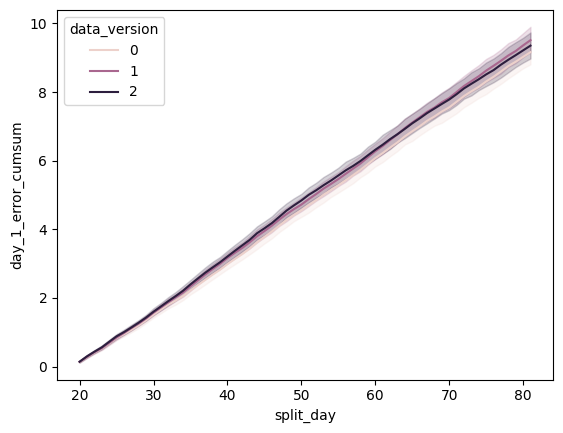

In [97]:
import seaborn as sns

sns.lineplot(data=results_group_df, x="split_day", y="day_1_error_cumsum", hue='data_version');

In [103]:
results_group_df.to_csv('results_group_df.csv', index=False)

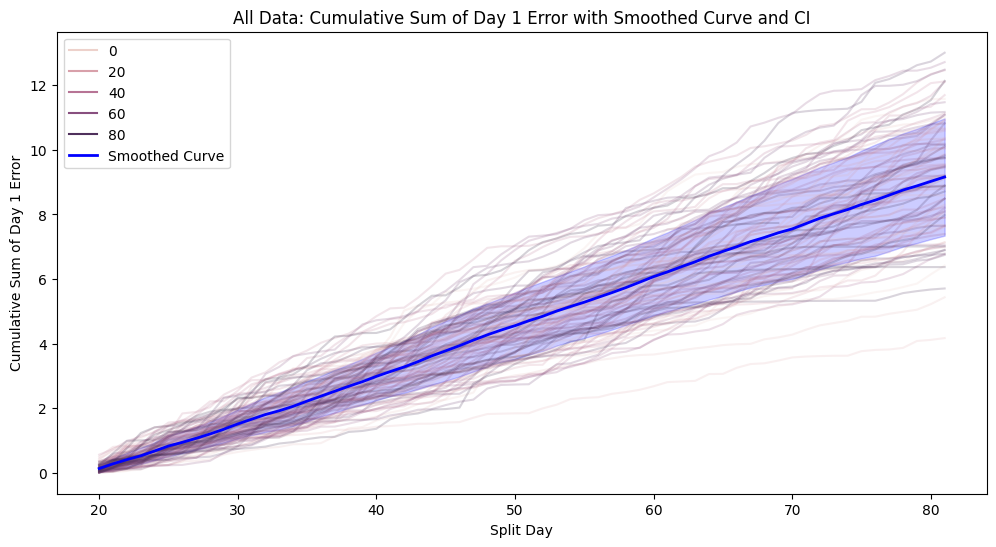

In [118]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Select rows with data_version equal to 0
df_filtered = results_group_df[results_group_df['data_version'] == 0]

# Plot each subject's data
plt.figure(figsize=(12, 6))
sns.lineplot(x='split_day', y='day_1_error_cumsum', hue='subject', data=df_filtered, legend='auto', alpha=0.2)

sns.lineplot(
    x='split_day', 
    y='day_1_error_cumsum', 
    data=df_filtered, 
    ci='sd', 
    color='blue', 
    label='Smoothed Curve', 
    linewidth=2
)
plt.xlabel('Split Day')
plt.ylabel('Cumulative Sum of Day 1 Error')
plt.title('All Data: Cumulative Sum of Day 1 Error with Smoothed Curve and CI')
plt.legend()
plt.show()

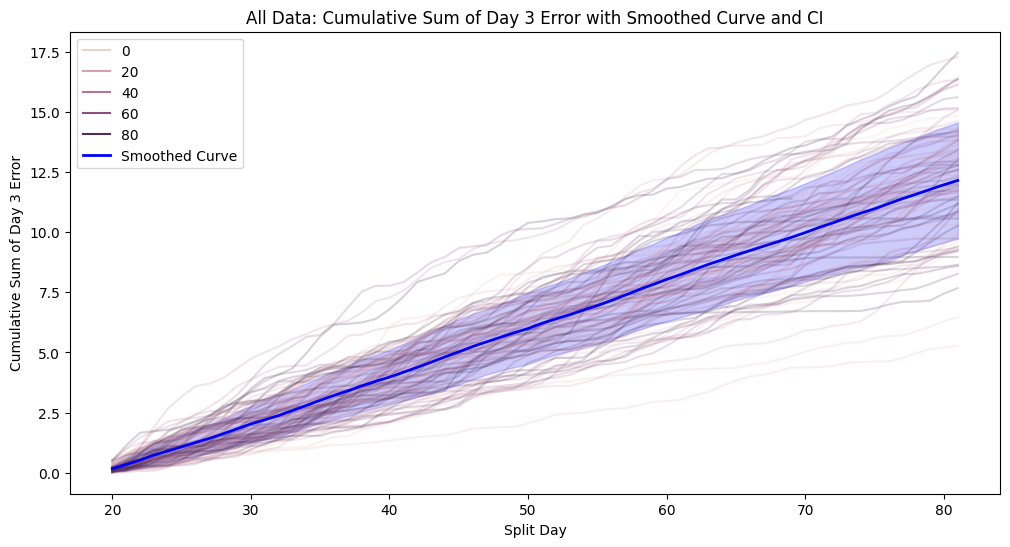

In [120]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Select rows with data_version equal to 0
df_filtered = results_group_df[results_group_df['data_version'] == 0]

# Plot each subject's data
plt.figure(figsize=(12, 6))
sns.lineplot(x='split_day', y='day_3_error_cumsum', hue='subject', data=df_filtered, legend='auto', alpha=0.2)

sns.lineplot(
    x='split_day', 
    y='day_3_error_cumsum', 
    data=df_filtered, 
    ci='sd', 
    color='blue', 
    label='Smoothed Curve', 
    linewidth=2
)
plt.xlabel('Split Day')
plt.ylabel('Cumulative Sum of Day 3 Error')
plt.title('All Data: Cumulative Sum of Day 3 Error with Smoothed Curve and CI')
plt.legend()
plt.show()

## Evaluation

In [145]:
df_good.sr_gap_heuristic

0        5.00
1       15.25
2       46.35
3       43.70
4       45.60
        ...  
8920    58.05
8921    26.25
8922    67.35
8923    52.15
8924      NaN
Name: sr_gap_heuristic, Length: 8925, dtype: float64

In [125]:
# Calculate baseline error
# Predicted value = value of previous day
results_group_df['day_0_actual'] = results_group_df.groupby(['subject', 'data_version'])['day_1_actual'].shift(1)

results_group_df['baseline_predict_error'] = np.abs(results_group_df['day_0_actual'] - results_group_df['day_1_actual'])

In [136]:
results_group_df.loc[(results_group_df.subject==0) & (results_group_df.data_version==0), ['baseline_predict_error', 'day_1_error_abs']].describe()

,baseline_predict_error,day_1_error_abs
count,61.000000,62.000000
mean,0.078820,0.103499
std,0.064219,0.088296
min,0.000812,0.000790
25%,0.028409,0.037568
50%,0.069399,0.083611
75%,0.115260,0.156965
max,0.282468,0.359643


In [162]:
results_group_df.loc[(results_group_df.data_version==0), ['baseline_predict_error', 'day_1_error_abs', 'day_2_error_abs', 'day_3_error_abs']].describe()

,baseline_predict_error,day_1_error_abs,day_2_error_abs,day_3_error_abs
count,5691.000000,5785.000000,5785.000000,5785.000000
mean,0.110632,0.147210,0.179424,0.195342
std,0.105591,0.122766,0.142704,0.152367
min,0.000000,0.000000,0.000000,0.000000
25%,0.031091,0.052900,0.068135,0.074359
50%,0.084472,0.117620,0.146651,0.162218
75%,0.160688,0.210302,0.258042,0.283838
max,0.941011,0.927168,0.921282,0.933533


In [172]:
# Calculate rolling median
results_group_df['expanding_median'] = results_group_df.groupby(['subject', 'data_version'])['day_0_actual'].expanding().median().reset_index(drop=True)
results_group_df['median'] = results_group_df.groupby(['subject', 'data_version'])['day_0_actual'].transform('median').reset_index(drop=True)

In [174]:
# Calculate baseline error
# Predicted value = median value of all days up until that point (e.g. did not have self report)

results_group_df['baseline_predict_median_exp_error'] = np.abs(results_group_df['day_0_actual'] - results_group_df['expanding_median'])
results_group_df['baseline_predict_median_error'] = np.abs(results_group_df['day_0_actual'] - results_group_df['median'])

In [175]:
results_group_df.loc[(results_group_df.data_version==0), ['baseline_predict_median_error', 'baseline_predict_median_exp_error', 'day_1_error_abs', 'day_2_error_abs', 'day_3_error_abs']].describe()

,baseline_predict_median_error,baseline_predict_median_exp_error,day_1_error_abs,day_2_error_abs,day_3_error_abs
count,5691.000000,5691.000000,5785.000000,5785.000000,5785.000000
mean,0.170333,0.163668,0.147210,0.179424,0.195342
std,0.135942,0.141098,0.122766,0.142704,0.152367
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.064246,0.049457,0.052900,0.068135,0.074359
50%,0.139246,0.129854,0.117620,0.146651,0.162218
75%,0.246226,0.242298,0.210302,0.258042,0.283838
max,0.762010,0.927168,0.927168,0.921282,0.933533


In [176]:
results_group_df.loc[(results_group_df.data_version==1), ['baseline_predict_median_error', 'baseline_predict_median_exp_error', 'day_1_error_abs', 'day_2_error_abs', 'day_3_error_abs']].describe()

,baseline_predict_median_error,baseline_predict_median_exp_error,day_1_error_abs,day_2_error_abs,day_3_error_abs
count,5691.000000,5691.000000,5785.000000,5785.000000,5785.000000
mean,0.170333,0.163668,0.153054,0.183840,0.199250
std,0.135942,0.141098,0.125383,0.143179,0.152317
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.064246,0.049457,0.055040,0.070315,0.078573
50%,0.139246,0.129854,0.123949,0.152315,0.164197
75%,0.246226,0.242298,0.217275,0.266695,0.290209
max,0.762010,0.927168,0.923193,0.921457,0.922314


In [177]:
results_group_df.loc[(results_group_df.data_version==2), ['baseline_predict_median_error', 'baseline_predict_median_exp_error', 'day_1_error_abs', 'day_2_error_abs', 'day_3_error_abs']].describe()

,baseline_predict_median_error,baseline_predict_median_exp_error,day_1_error_abs,day_2_error_abs,day_3_error_abs
count,5691.000000,5691.000000,5785.000000,5785.000000,5785.000000
mean,0.170333,0.163668,0.150222,0.181733,0.198327
std,0.135942,0.141098,0.125761,0.143926,0.152674
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.064246,0.049457,0.053522,0.068950,0.077355
50%,0.139246,0.129854,0.120196,0.147522,0.165090
75%,0.246226,0.242298,0.218116,0.265237,0.285459
max,0.762010,0.927168,0.922453,0.921282,0.863062


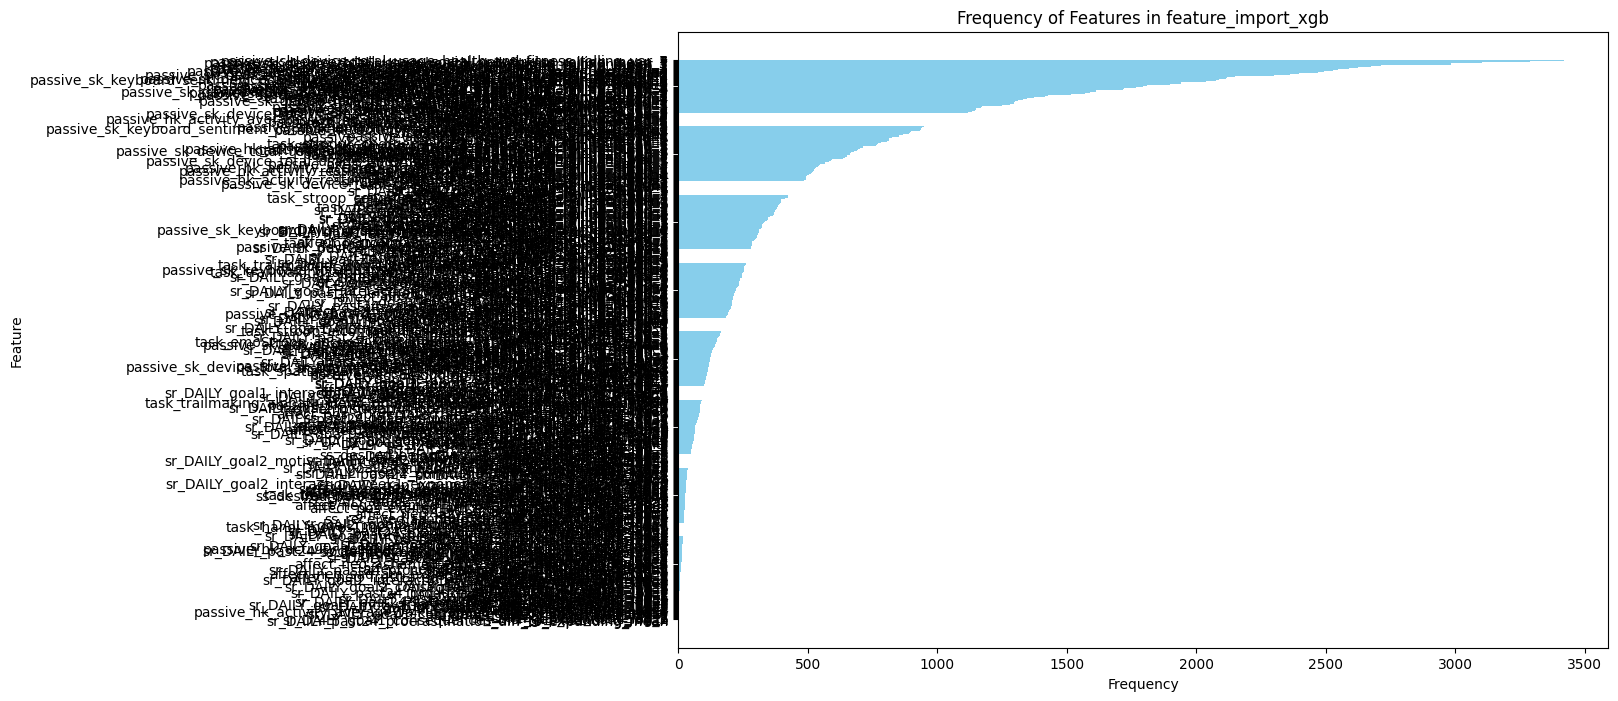

In [178]:
from collections import Counter


# Extract and parse the feature_import_xgb column
results_group_df['feature_import_xgb'] = results_group_df['feature_import_xgb'].apply(ast.literal_eval)

# Combine all dictionaries into one and count the frequency of each key
all_features = Counter()
for features in results_group_df['feature_import_xgb']:
    all_features.update(features.keys())

# Convert the counter to a DataFrame for visualization
feature_freq_df = pd.DataFrame.from_dict(all_features, orient='index', columns=['frequency']).reset_index()
feature_freq_df = feature_freq_df.rename(columns={'index': 'feature'})

# Sort by frequency for better visualization
feature_freq_df = feature_freq_df.sort_values(by='frequency', ascending=False)

# Plot the frequency of features
plt.figure(figsize=(12, 8))
plt.barh(feature_freq_df['feature'], feature_freq_df['frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Feature')
plt.title('Frequency of Features in feature_import_xgb')
plt.gca().invert_yaxis()  # Highest frequency at the top
plt.show()